In [1]:
import h5py
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Specify the OASIS path
directory_path = Path('./OASIS_preprocessed/train/')

# List all files in the directory that start with "input_" and sort them
input_files = list(directory_path.glob("input_*"))
input_files.sort()

# List all files in the directory that start with "label_" and sort them
label_files = list(directory_path.glob("label_*"))
label_files.sort()


print(input_files)
print(len(input_files))
print(label_files)
print(len(label_files))

[PosixPath('OASIS_preprocessed/train/input_0.nii.gz'), PosixPath('OASIS_preprocessed/train/input_1.nii.gz'), PosixPath('OASIS_preprocessed/train/input_10.nii.gz'), PosixPath('OASIS_preprocessed/train/input_100.nii.gz'), PosixPath('OASIS_preprocessed/train/input_101.nii.gz'), PosixPath('OASIS_preprocessed/train/input_102.nii.gz'), PosixPath('OASIS_preprocessed/train/input_103.nii.gz'), PosixPath('OASIS_preprocessed/train/input_104.nii.gz'), PosixPath('OASIS_preprocessed/train/input_105.nii.gz'), PosixPath('OASIS_preprocessed/train/input_106.nii.gz'), PosixPath('OASIS_preprocessed/train/input_107.nii.gz'), PosixPath('OASIS_preprocessed/train/input_108.nii.gz'), PosixPath('OASIS_preprocessed/train/input_109.nii.gz'), PosixPath('OASIS_preprocessed/train/input_11.nii.gz'), PosixPath('OASIS_preprocessed/train/input_110.nii.gz'), PosixPath('OASIS_preprocessed/train/input_111.nii.gz'), PosixPath('OASIS_preprocessed/train/input_112.nii.gz'), PosixPath('OASIS_preprocessed/train/input_113.nii.gz'

In [3]:
output_path = Path('./Synapse/train_npz')
train_txt_file = Path('../lists/lists_Synapse/train.txt')

with open(train_txt_file, 'w') as train_file:
    for input_file, label_file in zip(input_files, label_files):
        input_img = nib.load(input_file)
        label_img = nib.load(label_file)

        input_data = input_img.get_fdata()
        label_data = label_img.get_fdata()

        # Ensure the shapes are compatible
        assert input_data.shape == label_data.shape, "Input and label shapes don't match."

        # Create slices along the last dimension
        num_slices = input_data.shape[-1]

        for i in range(num_slices):
            input_slice = input_data[..., i]
            label_slice = label_data[..., i]

            # Normalize the input slice
            arr_min = input_slice.min()
            arr_max = input_slice.max()
            if arr_min == arr_max:
                # Set the normalized array to 0 
                input_slice = np.zeros(input_slice.shape)
            else:
                input_slice = (input_slice - arr_min) / (arr_max - arr_min)

            # Construct the output file name
            output_file_name = f"{Path(input_file).stem[:-4]}_slice{i:03}.npz"

            # Save slices as .npz files in the specified output directory
            output_file_path = output_path / output_file_name
            np.savez(output_file_path, image=input_slice, label=label_slice)

            
            # Write output_file_name to train.txt
            train_file.write(f"{output_file_name[:-4]}\n")


In [4]:
output_path = Path('./Synapse/test_vol_h5')
test_txt_file = Path('../lists/lists_Synapse/test_vol.txt')

with open(test_txt_file, 'w') as test_file:
    for input_file, label_file in zip(input_files, label_files):
        input_img = nib.load(input_file)
        label_img = nib.load(label_file)

        input_data = input_img.get_fdata()
        label_data = label_img.get_fdata()

        # Ensure the shapes are compatible
        assert input_data.shape == label_data.shape, "Input and label shapes don't match."

        # Normalize the input data
        arr_min = input_data.min()
        arr_max = input_data.max()
        input_data = (input_data - arr_min) / (arr_max - arr_min)

        # Create the h5 file

        # Construct the output file name
        output_file_name = f"{Path(input_file).stem[:-4]}.npy.h5"
        output_file_path = output_path / output_file_name

        with h5py.File(output_file_path, 'w') as file:
            file.create_dataset('image', data=input_data)
            file.create_dataset('label', data=label_data)

        # Write output_file_name to train.txt
        test_file.write(f"{output_file_name[:-7]}\n")

### Find differences between OASIS and Synapse data

In [2]:
import numpy as np

In [19]:
og_case = np.load('OG_Synapse/train_npz/case0005_slice080.npz')
og_case_img = og_case['image']
og_case_label = og_case['label']

new_case = np.load('Synapse/train_npz/input_0_slice040.npz')
new_case_img = new_case['image']
new_case_label = new_case['label']

In [20]:
print(f'OG img: {og_case_img.shape}\t {og_case_img.dtype}\t {np.min(og_case_img)} ... {np.max(og_case_img)}')
print(f'OG label: {og_case_label.shape}\t {og_case_label.dtype}\t {np.min(og_case_label)} ... {np.max(og_case_label)}')
print(f'New img: {new_case_img.shape}\t {new_case_img.dtype}\t {np.min(new_case_img)} ... {np.max(new_case_img)}')
print(f'New label: {new_case_label.shape}\t {new_case_label.dtype}\t {np.min(new_case_label)} ... {np.max(new_case_label)}')

OG img: (512, 512)	 float32	 0.0 ... 1.0
OG label: (512, 512)	 float32	 0.0 ... 8.0
New img: (64, 64)	 float64	 0.0 ... 1.0
New label: (64, 64)	 float64	 0.0 ... 4.0


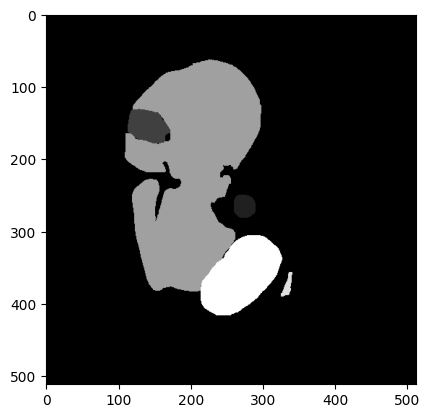

In [21]:
plt.imshow(og_case_label, cmap='gray')

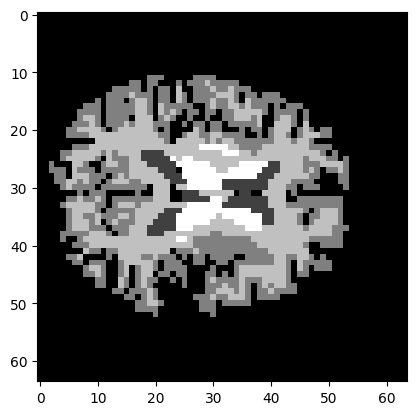

In [22]:
plt.imshow(new_case_label, cmap='gray')

### Find the reason for value 255 in label

In [2]:
import numpy as np
import os

In [5]:
# Directory containing npz files
directory = "./Synapse/train_npz"

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".npz"):
        file_path = os.path.join(directory, filename)
        # Load data from npz file
        data = np.load(file_path)
        unique_values = np.unique(data['label'])
        # Check if unique values are [0, 1, 2, 3, 4, 5, 6]
        if np.any(unique_values > 6):
            print(f"File: {filename}, Unique Values: {unique_values[unique_values > 6]}")

File: OAS1_0021_MR1_slice147.npz, Unique Values: [255.]
File: OAS1_0122_MR1_slice153.npz, Unique Values: [29.]
File: OAS1_0326_MR1_slice143.npz, Unique Values: [29.]
File: OAS1_0453_MR1_slice136.npz, Unique Values: [29.]
File: OAS1_0428_MR1_slice153.npz, Unique Values: [29.]
File: OAS1_0441_MR1_slice095.npz, Unique Values: [29.]
File: OAS1_0390_MR1_slice127.npz, Unique Values: [29.]
File: OAS1_0138_MR1_slice135.npz, Unique Values: [29.]
File: OAS1_0021_MR1_slice153.npz, Unique Values: [255.]
File: OAS1_0400_MR1_slice137.npz, Unique Values: [29.]
File: OAS1_0021_MR1_slice149.npz, Unique Values: [255.]
File: OAS1_0038_MR1_slice133.npz, Unique Values: [29.]
File: OAS1_0197_MR1_slice097.npz, Unique Values: [29.]
File: OAS1_0021_MR1_slice148.npz, Unique Values: [255.]
File: OAS1_0042_MR1_slice127.npz, Unique Values: [29.]
File: OAS1_0062_MR1_slice139.npz, Unique Values: [29.]
File: OAS1_0438_MR1_slice104.npz, Unique Values: [29.]
File: OAS1_0157_MR1_slice159.npz, Unique Values: [29.]


In [7]:
# left-undetermined to left white matter (29 -> 2)
# Corpus callosum part to Deep Gray Matter (255 -> 4)
file_names = ['OAS1_0021_MR1_slice147.npz', 'OAS1_0122_MR1_slice153.npz', 'OAS1_0326_MR1_slice143.npz', 'OAS1_0453_MR1_slice136.npz', 'OAS1_0428_MR1_slice153.npz', 'OAS1_0441_MR1_slice095.npz', 'OAS1_0390_MR1_slice127.npz', 'OAS1_0138_MR1_slice135.npz', 
              'OAS1_0021_MR1_slice153.npz', 'OAS1_0400_MR1_slice137.npz', 'OAS1_0021_MR1_slice149.npz', 'OAS1_0038_MR1_slice133.npz', 'OAS1_0197_MR1_slice097.npz', 'OAS1_0021_MR1_slice148.npz', 'OAS1_0042_MR1_slice127.npz', 'OAS1_0062_MR1_slice139.npz',
              'OAS1_0438_MR1_slice104.npz', 'OAS1_0157_MR1_slice159.npz']

for filename in file_names:
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and file_path.endswith(".npz"):
            # Load data from npz file
            image = np.load(file_path)['image']
            label = np.load(file_path)['label']
            # Replace values
            label[label == 29] = 2
            label[label == 255] = 4
            # Overwrite the file
            np.savez_compressed(file_path, image=image, label=label)
            print(f"Processed: {file_path}")


Processed: ./Synapse/train_npz/OAS1_0021_MR1_slice147.npz
Processed: ./Synapse/train_npz/OAS1_0122_MR1_slice153.npz
Processed: ./Synapse/train_npz/OAS1_0326_MR1_slice143.npz
Processed: ./Synapse/train_npz/OAS1_0453_MR1_slice136.npz
Processed: ./Synapse/train_npz/OAS1_0428_MR1_slice153.npz
Processed: ./Synapse/train_npz/OAS1_0441_MR1_slice095.npz
Processed: ./Synapse/train_npz/OAS1_0390_MR1_slice127.npz
Processed: ./Synapse/train_npz/OAS1_0138_MR1_slice135.npz
Processed: ./Synapse/train_npz/OAS1_0021_MR1_slice153.npz
Processed: ./Synapse/train_npz/OAS1_0400_MR1_slice137.npz
Processed: ./Synapse/train_npz/OAS1_0021_MR1_slice149.npz
Processed: ./Synapse/train_npz/OAS1_0038_MR1_slice133.npz
Processed: ./Synapse/train_npz/OAS1_0197_MR1_slice097.npz
Processed: ./Synapse/train_npz/OAS1_0021_MR1_slice148.npz
Processed: ./Synapse/train_npz/OAS1_0042_MR1_slice127.npz
Processed: ./Synapse/train_npz/OAS1_0062_MR1_slice139.npz
Processed: ./Synapse/train_npz/OAS1_0438_MR1_slice104.npz
Processed: ./S

In [1]:
import numpy as np

# Assuming x is your input array
x = np.random.random((1, 16, 16, 1))  # An example array with shape (1, 256, 256, 3)

B, H, W, C = x.shape

# Find factors of the height and width
height_factors = [i for i in range(1, H + 1) if H % i == 0]
width_factors = [i for i in range(1, W + 1) if W % i == 0]

# Find common factors
common_factors = set(height_factors) & set(width_factors)

# Choose a suitable window size
window_size = max(common_factors)

print("Common factors:", common_factors)
print("Suitable window size:", window_size)

Common factors: {1, 2, 4, 8, 16}
Suitable window size: 16
